# Value at Risk (VaR), Expected Shortfall (ES) and backtesting

In [498]:
import pandas as pd
import numpy as np
from scipy import stats
import datetime
import yfinance as yf
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.graphics.tsaplots as tsaplots
from arch import arch_model
import seaborn as sns
from statsmodels.stats.diagnostic import het_arch
from statsmodels.stats.diagnostic import acorr_ljungbox
from arch import arch_model
from scipy.stats import probplot
from statsmodels.compat import lzip

## I. VaR

Value at Risk (VaR) measures the potential loss in value of a portfolio V over a given time horizon l, at a specified confidence level 1-p. Mathematically: $$ \Pr[V_{t+\ell} - V_t \leq -\text{VaR}_\ell] = p $$

Note that we take $l = 1$ in this file. In any case, there is a rule of thumb: 

$$ \text{VaR}_{n-day} = \text{VaR}_{1-day} * \sqrt{l}$$

There are various methods of quantifying this risk metric

#### Data

Let's start with uploading the data:

In [7]:
p = 0.99                # confidence interval
assets = ['ASML',       # ASML
          'JPM',        # JPMorgan Chase
          'GOOGL',      # Alphabet
          'ABN.AS',     # ABN AMRO
          'ING',        # ING
          ]       

holdings = [100,200,300,400,500]          # number of shares in each assets

startdate = datetime.datetime(2021,12,31)
enddate = datetime.datetime(2023,12,31)


hist_data = {}
for asset in assets:
    data = yf.download(asset, start=startdate, end=enddate)
    hist_data[asset] = data['Adj Close']

hist_data = pd.DataFrame(hist_data).dropna()
hist_data

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


,ASML,JPM,GOOGL,ABN.AS,ING
Date,,,,,
2021-12-31,772.103882,145.585129,144.494217,9.900487,11.051376
2022-01-03,773.413025,148.665115,144.633362,10.066056,11.178403
2022-01-04,755.665588,154.300964,144.042831,10.614890,11.376884
2022-01-05,723.157593,151.479996,137.434692,10.801924,11.416579
2022-01-06,740.080750,153.089325,137.407257,10.831053,11.670633
...,...,...,...,...,...
2023-12-21,749.240540,163.593491,140.073151,12.191107,13.913521
2023-12-22,746.522400,163.495804,141.140518,12.200178,13.969286
2023-12-27,757.930603,165.449173,140.023270,12.381594,14.117994


#### Historical approach:
Historical VaR is calculated as the quantile of the empirical distribution of historical returns, which makes it the simplest approach. It does not assume any specific return distribution and includes outliers and extreme events.

Calculate the portfolio value and returns: 

In [10]:
portfolio = hist_data@holdings
hist_return = -(np.log(portfolio) - np.log(portfolio).shift()) #negative returns; whether we use negative or simple returns impacts what percentile, p or 1-p, respectively, would be used
hist_return = hist_return.dropna()
hist_return

Date
2022-01-03   -0.005754
2022-01-04    0.003166
2022-01-05    0.036392
2022-01-06   -0.013842
2022-01-07    0.003427
                ...   
2023-12-21   -0.021280
2023-12-22   -0.000374
2023-12-27   -0.008280
2023-12-28    0.003629
2023-12-29    0.001744
Length: 497, dtype: float64

In [11]:
hist_VaR = hist_return.quantile(p) #99% confidence level; note, that we use p-th percentile as hist_return are negative returns
print(f'VaR by historical simulation, %: {hist_VaR: .2%}\
      \nVaR by historical simulation, $: {hist_VaR*portfolio.iloc[-1]: ,.1f}')

VaR by historical simulation, %:  4.62%      
VaR by historical simulation, $:  7,491.7


#### VaR based on normal and t- distribution

Assuming $X_{t}\sim N(\mu ,\sigma ^{2})$, we can state that $$ \frac{X_{t} - \mu}{\sigma} \sim N(0 , 1)$$
hence $$\hat{x}_{p}^{t}=\hat{\mu}_{t} * l +z_{p}\hat{\sigma}_{t} * \sqrt{l}$$
where z is CDF of a std normal distribution, l is number of days (1 in our case) and $\hat{\mu}$ and $\hat{\sigma}$ are fitted values. Note, that $\mu \approx 0$, so it can be excluded from calculations 

In [14]:
z = stats.norm.ppf(p, 0, 1)
t = stats.t.ppf(p, len(hist_return) - 1)
mu = hist_return.mean()                         #approximately zero; added for the sake of completeness 

norm_VaR = mu + hist_return.std()*z
t_VaR = mu + hist_return.std()*t

print(f'VaR based on normal distribution, %: {norm_VaR: .2%}\
      \nVaR based on normal distribution, $: {norm_VaR*portfolio.iloc[-1]: ,.1f}')

print(f'VaR based on normal distribution, %: {t_VaR: .2%}\
      \nVaR based on normal distribution, $: {t_VaR*portfolio.iloc[-1]: ,.1f}')

VaR based on normal distribution, %:  4.46%      
VaR based on normal distribution, $:  7,232.5
VaR based on normal distribution, %:  4.48%      
VaR based on normal distribution, $:  7,256.0


The above-mentioned approaches are relatively simple, but have certain limitations:
- Historical simulation does not account for possible future scenarios that have not occurred in the historical data, is sensitive to the length of historical data, and assumes the future will behave like the past
- Distribution-based approaches rely on the assumption that the data follows a certain distribution, which often fails in financial markets due to skewness, kurtosis and volatility clustering

#### VaR based on a variance-covariance matrix

We use the fact that 
$$\text{Var}(R_p) = \text{Var}\left(\sum_{i=1}^n w_i R_i\right) = \mathbf{w}^\top \text{Var}(R_i) \mathbf{w} =  \mathbf{w}^\top \Sigma \mathbf{w}$$

where $\Sigma$ is a portfolio covariance matrix. So, $$\sigma = \sqrt{\mathbf{w}^\top \Sigma \mathbf{w}} $$
and 
$$VaR_{cov} = z * \sigma_{p} $$


In [18]:
hist_return_var = np.log(hist_data / hist_data.shift())
hist_return_var = hist_return_var.dropna()
w = holdings/np.sum(holdings)

port_cov = hist_return_var.cov()             

var_cov = w@port_cov@w
sigma = np.sqrt(var_cov) 
VaR_cov = z * sigma

print(f'VaR based on normal distribution, %: {VaR_cov: .2%}\
      \nVaR based on normal distribution, $: {VaR_cov*portfolio.iloc[-1]: ,.1f}')

VaR based on normal distribution, %:  3.97%      
VaR based on normal distribution, $:  6,432.9


The variance-covariance method is a fundamental and widely accepted approach for VaR calculation, as it uses weights and covariances to account for diversification effects in the portfolio. However, it still assumes normal distribution, which tends to underestimate risks and doesn't explain how much of that risk comes from each asset. This is accounted for by the correlations approach: 
$$ \text{VaR}(p) = \sqrt{\sum_{i=1}^m \sum_{j=1}^m \rho_{ij} \cdot \text{VaR}_i \cdot \text{VaR}_j} $$

In [437]:
port_corr = hist_return_var.corr() 

sigma_i = np.sqrt(np.diag(port_cov))  
w_i = hist_data.iloc[-1] * holdings                          # dollar value as of end_date
W = w_i.sum()                                                # dollar value of the portfolio

VaR_i = z * sigma_i * w_i                                    #dollar value
#VaR_i = z * sigma_i * (w_i/W)                               #percentages

VaR_corr_d = np.sqrt(VaR_i@port_corr@VaR_i)
VaR_corr = VaR_corr_d/portfolio.iloc[-1]

print(f'VaR based on normal distribution, %: {VaR_corr: .2%}\
      \nVaR based on normal distribution, $: {VaR_corr_d: ,.1f}')

VaR based on normal distribution, %:  4.49%      
VaR based on normal distribution, $:  7,277.9


To go further, Marginal VaR (MVaR) and Component VaR (CVaR) are introduced: MVaR measures the sensitivity of the portfolio VaR to changes in the weight of a particular asset, while CVaR shows the contribution of each asset to the portfolio's total VaR:

$$
\text{MVaR}_i = \frac{\text{VaR}_p}{W} \cdot \beta_i
$$


$$ 
\beta_i = \frac{\text{Cov}_{ip}}{\text{Var}(R_p)  /  {W^2}}
$$

$$
\text{Cov}_{ip} = \frac{\Sigma \cdot w_i}{W}
$$

$$
\text{CVaR}_i = \text{MVaR}_i \cdot w_i
$$


Note that the sum of component VaRs should match the portfolio VaR

In [23]:
w_i = hist_data.iloc[-1] * holdings                          # dollar value as of end_date
W = w_i.sum()                                                # dollar value of the portfolio

var_cov = w_i@port_cov@w_i                                   # cov in dollar amount
sigma_p = np.sqrt(var_cov)    
VaR_p = z * sigma_p                                          # portfolio VaR

cov_ip = np.dot(port_cov, w_i)/W                             # covariance
beta_i = cov_ip / (var_cov/(W**2))                           # beta
MVar_i = VaR_p/W*beta_i                                      # marginal var

CVaR_i = MVar_i * w_i                                        # component var

df = pd.DataFrame(
    data=np.column_stack((w_i, w_i / W, CVaR_i, CVaR_i / VaR_p, beta_i)),
    index=assets,
    columns=['Position ($)', 'Position (%)', 'CVaR ($)', 'CVaR (%)', 'Beta'])

df.loc['Total'] = [
    df['Position ($)'].sum(),
    df['Position (%)'].sum(),
    df['CVaR ($)'].sum(),
    df['CVaR (%)'].sum(),
    np.nan]

df.loc['Checks'] = [
    df[df.index != "Total"]['Position ($)'].sum() - W,
    df[df.index != "Total"]['Position (%)'].sum() - 1,
    df[df.index != "Total"]['CVaR ($)'].sum() - VaR_p,
    df[df.index != "Total"]['CVaR (%)'].sum() - 1,
    np.nan]

df = df.style.format({
    'Position ($)': '{:,.1f}',
    'Position (%)': '{:.1%}',
    'CVaR ($)': '{:,.1f}',
    'CVaR (%)': '{:.1%}',
    'Beta': '{:.2f}'
})

df

,Position ($),Position (%),CVaR ($),CVaR (%),Beta
ASML,"75,087.7",46.3%,"4,450.4",61.1%,1.32
JPM,"33,226.6",20.5%,821.6,11.3%,0.55
GOOGL,"41,803.5",25.8%,"1,684.2",23.1%,0.90
ABN.AS,"4,930.9",3.0%,90.5,1.2%,0.41
ING,"6,980.0",4.3%,231.2,3.2%,0.74
Total,"162,028.7",100.0%,"7,277.9",100.0%,nan
Checks,0.0,0.0%,0.0,0.0%,nan


## II. Backtesing

Now that we have a number of models at our disposal, we can compare them and, most importantly, check their sanity. There are 2 good ways to do that: 
- to construct exact tests of $H_0 : p = p_0$ against one-sided or two-sided alternatives, based on $\hat{p}$ = m/n
$$t = \frac{\hat{p} - (1 - p)}{\sqrt{{p(1 - p)}/{n}}}$$
where $\hat{p}$ are hits (aka breaches), are exceedances of negative historical returns over the projected VaR

- to implement Christoffersen likelihood test, which tests whether the observed frequency of breaches matches the expected frequency and whether breaches are independent over time. For this we need to calculate the following

$$
\begin{align*}
N_{00} &= \sum_{t=1}^{T} \mathbb{1}\{x_{t-1} = 0, x_t = 0\} \\
N_{01} &= \sum_{t=1}^{T} \mathbb{1}\{x_{t-1} = 0, x_t = 1\} \\
N_{10} &= \sum_{t=1}^{T} \mathbb{1}\{x_{t-1} = 1, x_t = 0\} \\
N_{11} &= \sum_{t=1}^{T} \mathbb{1}\{x_{t-1} = 1, x_t = 1\} \\
\end{align*}
$$
where x are "breaches", i.e., $N_{00}$ is number of times no breach is followed by no breach, $N_{01}$ is the number of times no breach is followed by a breach and so on
$$
\begin{align*}
\pi_0 &= \frac{N_{01}}{N_{00} + N_{01}} \\
\pi_1 &= \frac{N_{11}}{N_{10} + N_{11}} \\
\pi &= \frac{N_{01} + N_{11}}{T} \\
\end{align*}
$$

The LR statistic 
$$
\begin{align*}
LR &= -2 \left( N_{00} \ln(1 - \pi) + N_{01} \ln(\pi) + N_{10} \ln(1 - \pi) + N_{11} \ln(\pi) \right) \\
&\quad + 2 \left( N_{00} \ln(1 - \pi_0) + N_{01} \ln(\pi_0) + N_{10} \ln(1 - \pi_1) + N_{11} \ln(\pi_1) \right) \\
\end{align*}
$$
is calculated against $\chi^2$ distribution qith 1 df, with the null of serial independence 

In [408]:
def christoffersen_independence_test(hits):
    T = len(hits) - 1
    I0 = hits[:-1].values
    I1 = hits[1:].values
    
    epsilon = 1e-10 # I add epsilon in case somw of the statistic are zero, in which case the log is not defined
    
    N00 = ((I0 == False) & ( I1 == False)).sum()+epsilon
    N01 = ((I0 == False) & (I1  == True)).sum()+epsilon
    N10 = ((I0 == True) & (I1 == False)).sum()+epsilon
    N11 = ((I0 == True) & (I1 == True)).sum()+epsilon

    # Transition probabilities
    pi_0 = N01 / (N00 + N01)
    pi_1 = N11 / (N10 + N11)
    pi = (N01 + N11) / T

    # Likelihood ratio test
    LR = -2 * (N00 * np.log(1 - pi) + N01 * np.log(pi) +
               N10 * np.log(1 - pi) + N11 * np.log(pi) -
               (N00 * np.log(1 - pi_0) + N01 * np.log(pi_0) +
                N10 * np.log(1 - pi_1) + N11 * np.log(pi_1)))
    p_value = stats.chi2.sf(LR, df=1)
    return p_value

In [474]:
bt = pd.DataFrame(columns = ['Hits', 't-stat', "Christoffersen-stat (p-value)"])
var_descriptions = ['Historical VaR', 'Normal VaR', 't-Distribution VaR', 'Variance-Covariance VaR', 'Correlation approach']

p=0.99

for var, description in zip([hist_VaR, norm_VaR, t_VaR, VaR_cov, VaR_corr], var_descriptions):
    hits = hist_return > var * 100
    p_hat = hits.mean()
    bt.loc[description, 'Hits'] = p_hat
    SE = np.sqrt(p * (1 - p) / len(hist_return))
    bt.loc[description, 't-stat'] = (p_hat - (1-p))/SE
    bt.loc[description, 'Christoffersen-stat (p-value)'] = christoffersen_independence_test(hits)
    
bt

,Hits,t-stat,Christoffersen-stat (p-value)
Historical VaR,0.01006,0.013525,0.749639
Normal VaR,0.012072,0.464346,0.701475
t-Distribution VaR,0.012072,0.464346,0.701475
Variance-Covariance VaR,0.028169,4.070914,0.367119
Correlation approach,0.012072,0.464346,0.701475


Note that historical VaR is by construction such that its "breaches" are not significantly different from the confidence level. As can be expected, approach, that disregards the impact of individual assets is the least precise one. As for Christoffersen test, for all of the approaches we soundly fail to reject the null of serial independence

Still, in some cases the "breaches" could be dependent. The so-called volatility clustering can occur during crises, which can be accounted for by ARMA-GARCH modelling.

#### ARMA-GARCH approach

Since python doesn't support multidimensional ARMA-GARCH modelling yet, we would stick to using portfolio returns as a whole. Hopefully, I will post more theory on ARMA-GARCH itself later

D:\Python\Anaconda\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
D:\Python\Anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


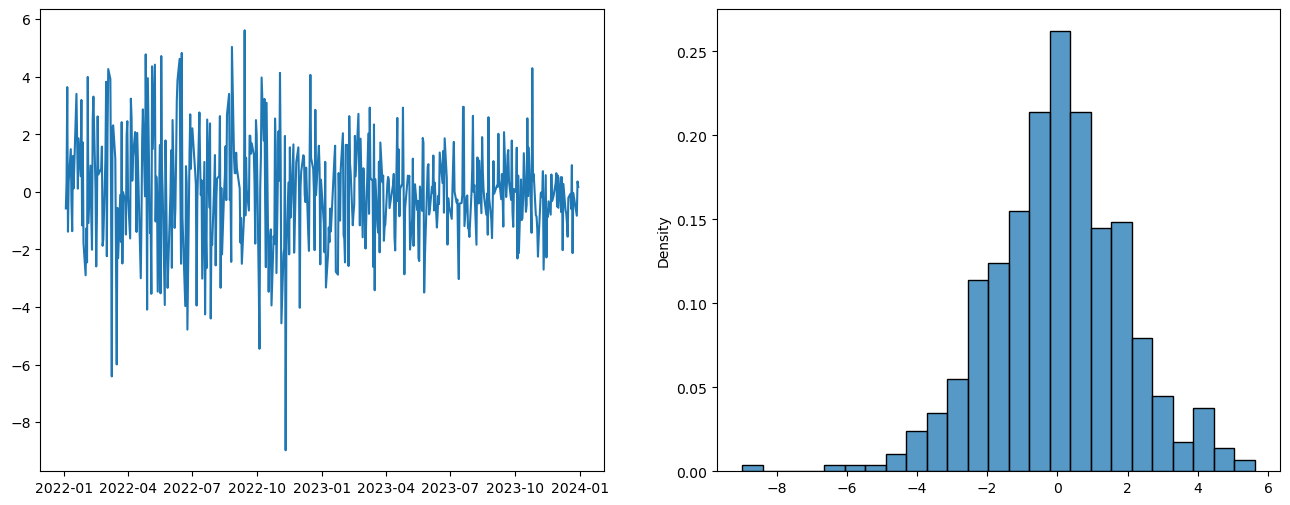

In [27]:
hist_return = 100*hist_return   #scale data for better accuracy

plt.figure(figsize=(16,6))
plt.subplot(121)
plt.plot(hist_return)
plt.subplot(122)
sns.histplot(hist_return, stat='density');

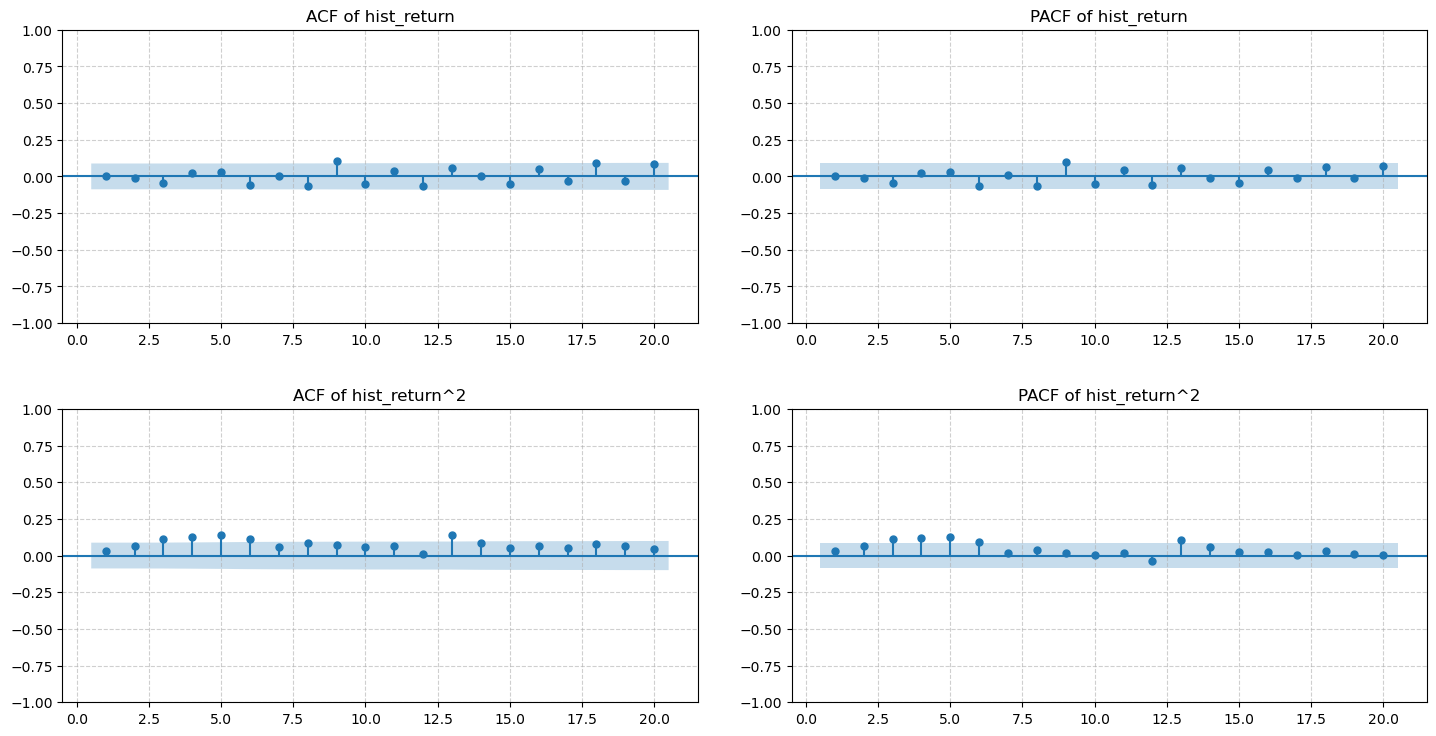

In [28]:
plt.figure(figsize=(15, 8)) 
nlags = 20

ax1 = plt.subplot(221)
tsaplots.plot_acf(hist_return, lags=nlags, zero=False, ax=ax1)
ax1.set_title("ACF of hist_return")
ax1.set_ylim(-1, 1)
ax1.grid(True, linestyle='--', alpha=0.6)

ax2 = plt.subplot(222)
tsaplots.plot_pacf(hist_return, lags=nlags, zero=False, ax=ax2)
ax2.set_title("PACF of hist_return")
ax2.set_ylim(-1, 1)
ax2.grid(True, linestyle='--', alpha=0.6)

ax3 = plt.subplot(223)
tsaplots.plot_acf(hist_return**2, lags=nlags, zero=False, ax=ax3)
ax3.set_title("ACF of hist_return^2")
ax3.set_ylim(-1, 1)
ax3.grid(True, linestyle='--', alpha=0.6)

ax4 = plt.subplot(224)
tsaplots.plot_pacf(hist_return**2, lags=nlags, zero=False, ax=ax4)
ax4.set_title("PACF of hist_return^2")
ax4.set_ylim(-1, 1)
ax4.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout(pad=3) 
plt.show()

Thus, we can state, that returns exhibit weak autocorrelation and no strong lag dependence, while time-varying volatility is present. So we will use ARMA(0,0)-GARCH(1,1) model, with a t-distribution to account for fatter tails 

In [30]:
amt = arch_model(hist_return, mean='AR', lags=0, vol='GARCH', p=1, q=1, dist='t')
rest = amt.fit();
print(rest.summary())

Iteration:      1,   Func. Count:      7,   Neg. LLF: 44466.16517327913
Iteration:      2,   Func. Count:     16,   Neg. LLF: 1755.231413187262
Iteration:      3,   Func. Count:     25,   Neg. LLF: 1701.3089656940988
Iteration:      4,   Func. Count:     33,   Neg. LLF: 996.2916230667777
Iteration:      5,   Func. Count:     39,   Neg. LLF: 1081.1800850013742
Iteration:      6,   Func. Count:     47,   Neg. LLF: 996.0288387235473
Iteration:      7,   Func. Count:     53,   Neg. LLF: 996.3862145861353
Iteration:      8,   Func. Count:     60,   Neg. LLF: 995.9485791757148
Iteration:      9,   Func. Count:     67,   Neg. LLF: 995.8833116442411
Iteration:     10,   Func. Count:     73,   Neg. LLF: 995.7630624330405
Iteration:     11,   Func. Count:     79,   Neg. LLF: 995.6212127061513
Iteration:     12,   Func. Count:     85,   Neg. LLF: 995.5735718048765
Iteration:     13,   Func. Count:     91,   Neg. LLF: 995.5547207061759
Iteration:     14,   Func. Count:     97,   Neg. LLF: 995.5504

In [31]:
rez = rest.resid / rest.conditional_volatility   #standardized residuals
rez = rez.dropna()
rez.head()

Date
2022-01-03   -0.263504
2022-01-04    0.201367
2022-01-05    1.974596
2022-01-06   -0.676498
2022-01-07    0.212058
dtype: float64

In [33]:
mu = hist_return - rest.resid                                               # fitted values
sig = rest.conditional_volatility
nu = rest.params.loc['nu']
VaR_GARCHt = mu + sig*stats.t.ppf(p, df=nu, scale = np.sqrt((nu-2)/nu))  # Correct scale s.t. ppf of standardized t distr

Check the sanity of the model: residuals and squared residuals should not exhibit autocorrelation, there should be no remaining heteroskedasticity in the residuals, standardized residuals should be i.i.d.

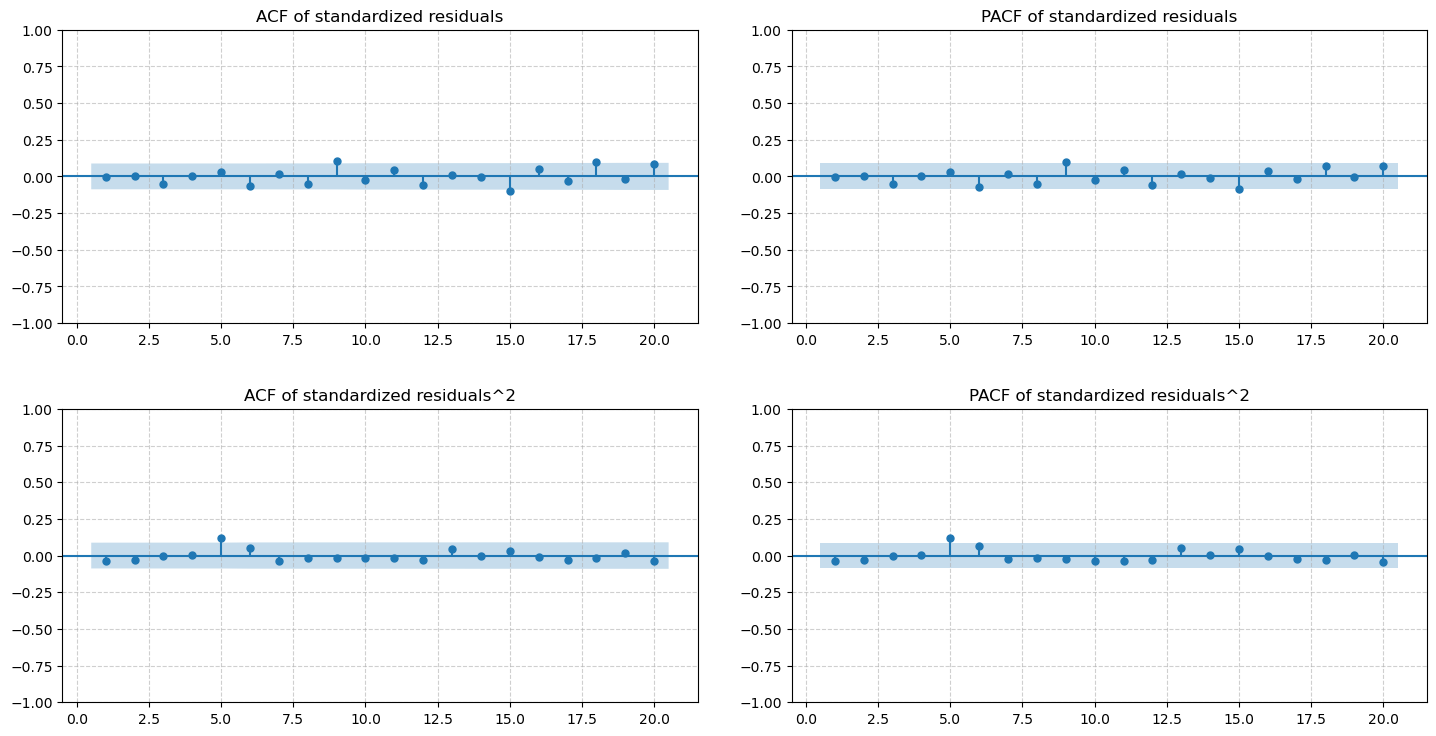

In [487]:
plt.figure(figsize=(15, 8)) 
nlags = 20

ax1 = plt.subplot(221)
tsaplots.plot_acf(rez, lags=nlags, zero=False, ax=ax1)
ax1.set_title("ACF of standardized residuals")
ax1.set_ylim(-1, 1)
ax1.grid(True, linestyle='--', alpha=0.6)

ax2 = plt.subplot(222)
tsaplots.plot_pacf(rez, lags=nlags, zero=False, ax=ax2)
ax2.set_title("PACF of standardized residuals")
ax2.set_ylim(-1, 1)
ax2.grid(True, linestyle='--', alpha=0.6)

ax3 = plt.subplot(223)
tsaplots.plot_acf(rez**2, lags=nlags, zero=False, ax=ax3)
ax3.set_title("ACF of standardized residuals^2")
ax3.set_ylim(-1, 1)
ax3.grid(True, linestyle='--', alpha=0.6)

ax4 = plt.subplot(224)
tsaplots.plot_pacf(rez**2, lags=nlags, zero=False, ax=ax4)
ax4.set_title("PACF of standardized residuals^2")
ax4.set_ylim(-1, 1)
ax4.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout(pad=3) 
plt.show()

Ljung-Box Test for Residuals:
      lb_stat  lb_pvalue
10  11.451012   0.323475

Ljung-Box Test for Squared Residuals:
      lb_stat  lb_pvalue
10  10.930609    0.36295

ARCH Effect Test:
[('LM', 11.558994029184932), ('p-value (LM)', 0.31565457024168003), ('F', 1.1572584377018948), ('p-value (F)', 0.31775350264684654)]


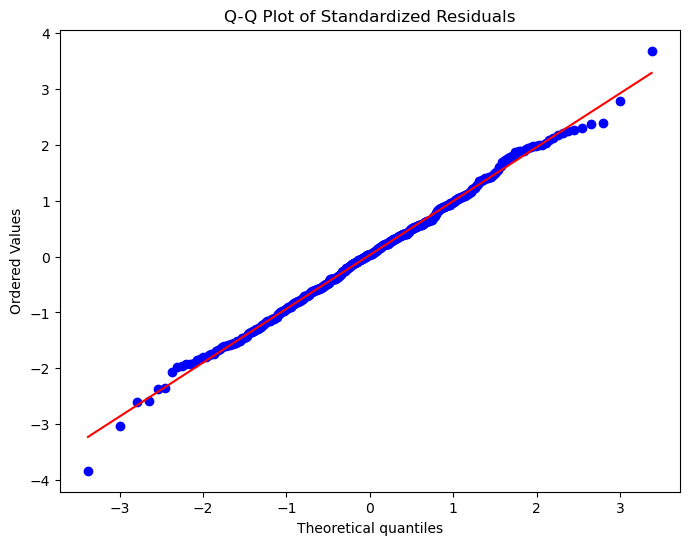

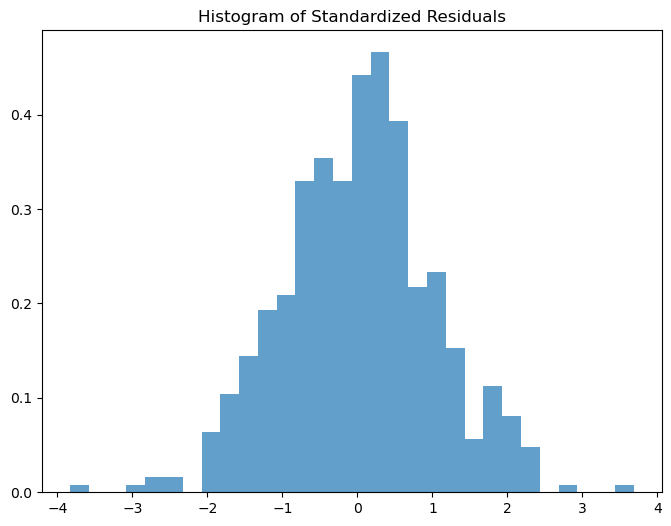

In [521]:
# 1. Test for Autocorrelation (Ljung-Box Test)
print("Ljung-Box Test for Residuals:")
lb_resid = acorr_ljungbox(rez, lags=[10], return_df=True)
print(lb_resid)

print("\nLjung-Box Test for Squared Residuals:")
lb_sq_resid = acorr_ljungbox(rez**2, lags=[10], return_df=True)
print(lb_sq_resid)



# 2. Test for Heteroskedasticity (ARCH Effect Test)
print("\nARCH Effect Test:")
name = ['LM','p-value (LM)','F','p-value (F)']
test = sm.stats.diagnostic.het_arch(rez)  
print(lzip(name, test))


# 3. Q-Q Plot for standardized residuals
plt.figure(figsize=(8, 6))
probplot(rez, dist="t", sparams=(nu,), plot=plt)
plt.title("Q-Q Plot of Standardized Residuals")
plt.show()

# 4. Histogram of standardized residuals
plt.figure(figsize=(8, 6))
plt.hist(rez, bins=30, density=True, alpha=0.7)
plt.title("Histogram of Standardized Residuals")
plt.show()


So the model satisfies the requirements. More detailed information on ARMA-GARCH modelling will be in a separate file

We get a series of VaR values. Indeed, here VaR changes over time, reflecting the dynamic nature of financial markets, unlike with the previous approaches, where constant volatility was assumed over the whole sample period

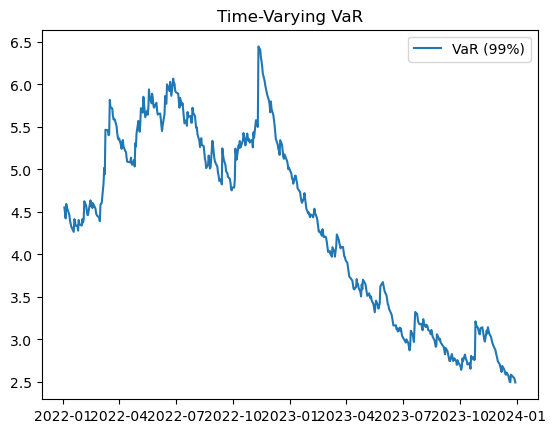

In [35]:
plt.plot(VaR_GARCHt, label='VaR (99%)')
plt.title('Time-Varying VaR')
plt.legend()
plt.show()

#### Backtesting

In [485]:
hits = hist_return > VaR_GARCHt 

p_hat = hits.mean()  
SE = np.sqrt((p* (1 - p)) / len(hist_return))

kupiec_stat = (p_hat - (1 - p)) / SE 
christoffersen_stat = christoffersen_independence_test(hits)


print(f'Kupiec Test (t-stat): {kupiec_stat:.2f}\
        \nChristoffersen Test (p-value): {christoffersen_stat:.2f} ')


Kupiec Test (t-stat): -0.89        
Christoffersen Test (p-value): 0.85 


## III. Expected Shortfall (ES)

VaR only specifies the maximum potential loss at a certain confidence level (e.g., 99%) but gives no information about what happens beyond that threshold. Moreover, VaR is not subadditive, meaning that the VaR of a portfolio can exceed the sum of individual VaRs of its components, hence violating a basic property of coherent risk measures. Expected Shortfall (ES) overcomes these limitations by providing a more comprehensive view of extreme losses: 
$$\text{ES}_\alpha = \mathbb{E}[\text{Loss} \mid \text{Loss} > \text{VaR}_\alpha] $$

Like in case with VaR, ES can be obtained by means of historic simulation and parametric approach:

In [39]:
hist_ES = np.mean(hist_return[hist_return > hist_return.quantile(p)])/100
print(f'ES by historical simulation, %: {hist_ES: .2%}\
      \nES by historical simulation, $: {hist_ES*portfolio.iloc[-1]: ,.1f}') 

ES by historical simulation, %:  4.99%      
ES by historical simulation, $:  8,091.9


$$\text{ES}_\alpha = \frac{\sigma_p \cdot \phi(z_\alpha)}{1 - \alpha}$$

In [533]:
ES_parametric = sigma * stats.norm.pdf(z) / (1 - p)

print(f"Parametric ES, %: {ES_parametric:.2%}\
        \nParametric ES, $: {ES_parametric*portfolio.iloc[-1]: ,.1f}")

Parametric ES, %: 4.55%        
Parametric ES, $:  7,370.0
